In [1]:
from sklearn.model_selection import StratifiedKFold, train_test_split
import numpy as np
import pandas as pd
from category_encoders import woe
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from scipy import sparse
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.datasets import fetch_openml

In [2]:
def preprocess_and_split(X, Y, num_fold=10):
    skf = StratifiedKFold(n_splits=num_fold)

    for train_index, test_index in skf.split(X, Y):
        yield train_index, test_index

In [3]:
data = fetch_openml(data_id=1558)

/mnt/sda/boris_stanoev/PropStar/venv/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
data.data.rename(columns={"V1": "age",
                                   "V2": "job",
                                   "V3": "marital",
                                   "V4": "education",
                                   "V5": "default",
                                   "V6": "balance",
                                   "V7": "housing",
                                   "V8": "loan",
                                   "V9": "contact",
                                   "V10": "day",
                                   "V11": "month",
                                   "V12": "duration",
                                   "V13": "campaign",
                                   "V14": "pdays",
                                   "V15": "previous",
                                   "V16": "poutcome",
                                  }, inplace=True)

/tmp/ipykernel_958458/666150026.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.data.rename(columns={"V1": "age",


In [5]:
data.data.count()

age          4521
job          4521
marital      4521
education    4521
default      4521
balance      4521
housing      4521
loan         4521
contact      4521
day          4521
month        4521
duration     4521
campaign     4521
pdays        4521
previous     4521
poutcome     4521
dtype: int64

In [6]:
data.data.dtypes

age           float64
job          category
marital      category
education    category
default      category
balance       float64
housing      category
loan         category
contact      category
day           float64
month        category
duration      float64
campaign      float64
pdays         float64
previous      float64
poutcome     category
dtype: object

In [7]:
woe_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

# ML test

In [34]:
X = data.data.copy()
y = data.target.copy()

In [35]:
vectorizer = woe.WOEEncoder(cols=woe_cols)
# vectorizer = preprocessing.OneHotEncoder(handle_unknown='ignore')
label_encoder = preprocessing.LabelEncoder()

split_gen = preprocess_and_split(X, y, num_fold=5)

for train_index, test_index in split_gen:
    X_train = X.iloc[train_index, :].copy()
    y_train = y.iloc[train_index].copy()
    X_test = X.iloc[test_index, :].copy()
    y_test = y.iloc[test_index].copy()
    train_y = label_encoder.fit_transform(y_train)
    test_y = label_encoder.transform(y_test)
    
    unique_classes = set(y_test)
    print(f"Unique classes:{unique_classes}")
    # woe_data = [woe_cols].copy()
    
    woe_train_features = vectorizer.fit_transform(X=X_train[woe_cols], y=train_y)
    woe_test_features = vectorizer.transform(X=X_test[woe_cols])
    original_train_df = X_train.copy()
    original_train_df.update(woe_train_features)
    
    original_test_df = X_test.copy()
    original_test_df.update(woe_test_features)
    
    train_x = original_train_df.copy()
    test_x = original_test_df.copy()
    print("model init")
    model = ExtraTreesClassifier(n_estimators=16,
                               random_state=0)
    print(train_x.dtypes)
    model.fit(train_x, train_y)
    predictions = model.predict(test_x)
    predictions_scores = model.predict_proba(test_x)
    
    acc = accuracy_score(test_y, predictions)
    f1 = f1_score(test_y, predictions)
    print(f'ACC: {acc}')
    print(f'F1: {f1}')
    roc = roc_auc_score(test_y, predictions_scores[:,1])
    print(f'ROC AUC: {roc}')

Unique classes:{'1', '2'}
model init
age          float64
job           object
marital       object
education     object
default       object
balance      float64
housing       object
loan          object
contact       object
day          float64
month         object
duration     float64
campaign     float64
pdays        float64
previous     float64
poutcome      object
dtype: object
ACC: 0.8972375690607735
F1: 0.392156862745098
ROC AUC: 0.8680178571428573
Unique classes:{'1', '2'}
model init
age          float64
job           object
marital       object
education     object
default       object
balance      float64
housing       object
loan          object
contact       object
day          float64
month         object
duration     float64
campaign     float64
pdays        float64
previous     float64
poutcome      object
dtype: object
ACC: 0.8926991150442478
F1: 0.348993288590604
ROC AUC: 0.8348617788461539
Unique classes:{'1', '2'}
model init
age          float64
job           object

# Fit/test original columns

In [8]:
X = data.data.copy()
y = data.target.copy()

In [10]:
vectorizer = woe.WOEEncoder(cols=woe_cols)
# vectorizer = preprocessing.OneHotEncoder(handle_unknown='ignore')
label_encoder = preprocessing.LabelEncoder()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
train_y = label_encoder.fit_transform(y_train)
test_y = label_encoder.transform(y_test)

unique_classes = set(y_test)
print(f"Unique classes:{unique_classes}")
# woe_data = [woe_cols].copy()

woe_train_features = vectorizer.fit_transform(X=X_train[woe_cols], y=train_y)
woe_test_features = vectorizer.transform(X=X_test[woe_cols])
original_train_df = X_train.copy()
original_train_df.update(woe_train_features)

original_test_df = X_test.copy()
original_test_df.update(woe_test_features)

train_x = original_train_df.copy()
test_x = original_test_df.copy()
print("model init")
model = ExtraTreesClassifier(n_estimators=16,
                           random_state=42)
print(train_x.dtypes)
model.fit(train_x, train_y)
predictions = model.predict(test_x)
predictions_scores = model.predict_proba(test_x)

acc = accuracy_score(test_y, predictions)
f1 = f1_score(test_y, predictions)
print(f'ACC: {acc}')
print(f'F1: {f1}')
roc = roc_auc_score(test_y, predictions_scores[:,1])
print(f'ROC AUC: {roc}')

Unique classes:{'1', '2'}
model init
age          float64
job           object
marital       object
education     object
default       object
balance      float64
housing       object
loan          object
contact       object
day          float64
month         object
duration     float64
campaign     float64
pdays        float64
previous     float64
poutcome      object
dtype: object
ACC: 0.8983050847457628
F1: 0.37272727272727274
ROC AUC: 0.8548482201354008


**Columns unique values**

In [13]:
for col in train_x.columns.values:
    cnt = len(train_x[col].unique())
    print(f'{col}-{cnt}')

age-64
job-12
marital-3
education-4
default-2
balance-1795
housing-2
loan-2
contact-3
day-31
month-12
duration-765
campaign-32
pdays-250
previous-22
poutcome-4


### Feature importance based on mean decrease in impurity

In [29]:
import time
start_time = time.time()
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.003 seconds


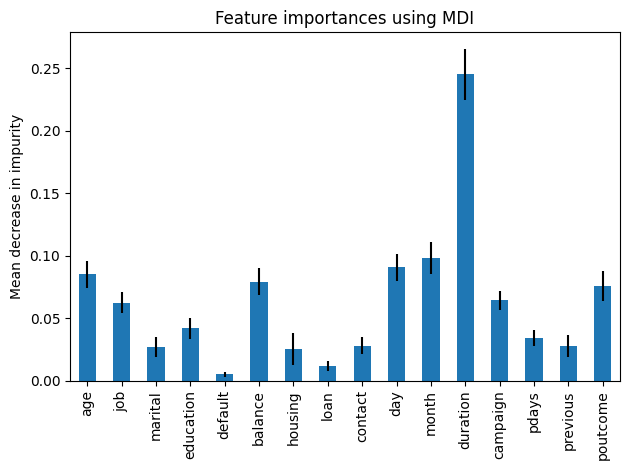

In [30]:
import matplotlib.pyplot as plt

forest_importances = pd.Series(importances, index=list(train_x.columns.values))

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [16]:
forest_importances[forest_importances <0.03]

default     0.006092
housing     0.027673
loan        0.016285
contact     0.027325
previous    0.027244
dtype: float64

# Fit/test added random columns

In [17]:
X = data.data.copy()
y = data.target.copy()

In [18]:
for i in range(10):
    X[f'fake_{i}'] = np.random.rand(len(X))

In [19]:
vectorizer = woe.WOEEncoder(cols=woe_cols)
# vectorizer = preprocessing.OneHotEncoder(handle_unknown='ignore')
label_encoder = preprocessing.LabelEncoder()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

train_y = label_encoder.fit_transform(y_train)
test_y = label_encoder.transform(y_test)

unique_classes = set(y_test)
print(f"Unique classes:{unique_classes}")

woe_train_features = vectorizer.fit_transform(X=X_train[woe_cols], y=train_y)
woe_test_features = vectorizer.transform(X=X_test[woe_cols])

original_train_df = X_train.copy()
original_train_df.update(woe_train_features)

original_test_df = X_test.copy()
original_test_df.update(woe_test_features)

train_x = original_train_df.copy()
test_x = original_test_df.copy()
model = ExtraTreesClassifier(n_estimators=16,
                           random_state=42)
model.fit(train_x, train_y)

predictions = model.predict(test_x)
predictions_scores = model.predict_proba(test_x)


acc = accuracy_score(test_y, predictions)
f1 = f1_score(test_y, predictions)
print(f'ACC: {acc}')
print(f'F1: {f1}')
roc = roc_auc_score(test_y, predictions_scores[:,1])
print(f'ROC AUC: {roc}')

Unique classes:{'2', '1'}
ACC: 0.8994638069705094
F1: 0.2857142857142857
ROC AUC: 0.8577206649839637


In [20]:
train_x

,age,job,marital,education,default,balance,housing,loan,contact,day,...,fake_0,fake_1,fake_2,fake_3,fake_4,fake_5,fake_6,fake_7,fake_8,fake_9
1138,35.0,-0.07942,0.211126,-0.077967,-0.007056,56.0,0.333398,0.06931,0.243729,29.0,...,0.308678,0.040250,0.885191,0.553556,0.452216,0.996354,0.280583,0.926077,0.595011,0.137727
209,56.0,0.874826,-0.127721,-0.077967,-0.007056,1333.0,0.333398,0.06931,0.243729,28.0,...,0.834573,0.319763,0.763615,0.480292,0.085415,0.575526,0.302110,0.629063,0.614216,0.888637
2609,57.0,0.179665,-0.127721,-0.235436,-0.007056,-226.0,-0.341013,0.06931,-0.933975,4.0,...,0.021407,0.992202,0.794754,0.958170,0.217354,0.908152,0.967542,0.658120,0.289674,0.728326
2110,31.0,-0.488751,-0.127721,-0.077967,-0.007056,-498.0,-0.341013,0.06931,0.243729,21.0,...,0.054519,0.420626,0.179453,0.373794,0.274531,0.005315,0.789037,0.377681,0.414399,0.793813
2124,43.0,0.179665,-0.127721,0.245477,-0.007056,291.0,-0.341013,0.06931,-0.933975,9.0,...,0.753357,0.417130,0.346653,0.000119,0.864326,0.535627,0.100142,0.699270,0.854584,0.462403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4426,41.0,0.170657,-0.127721,0.245477,-0.007056,1536.0,0.333398,0.06931,0.243729,4.0,...,0.539105,0.263686,0.244703,0.904241,0.903135,0.466216,0.456820,0.254389,0.287835,0.025371
466,34.0,0.06881,-0.127721,-0.077967,-0.007056,-370.0,-0.341013,0.06931,-0.933975,21.0,...,0.054706,0.728743,0.390384,0.858099,0.526354,0.737049,0.035405,0.763903,0.374906,0.774488
3092,46.0,0.179665,-0.127721,0.245477,-0.007056,523.0,-0.341013,0.06931,0.243729,6.0,...,0.981408,0.757106,0.207020,0.721096,0.812141,0.710887,0.745383,0.455152,0.965556,0.028763
3772,47.0,0.179665,0.184356,0.245477,-0.007056,440.0,0.333398,0.06931,0.243729,21.0,...,0.778481,0.052324,0.437654,0.592056,0.459190,0.451454,0.173612,0.419471,0.406064,0.058194


### Feature importance based on mean decrease in impurity

In [21]:
import time
start_time = time.time()
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.002 seconds


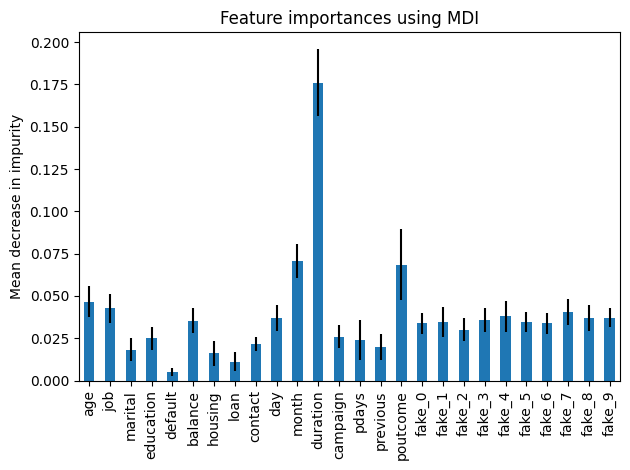

In [22]:
import matplotlib.pyplot as plt

forest_importances = pd.Series(importances, index=list(train_x.columns.values))

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Boruta experiment

In [23]:
from boruta import BorutaPy

In [24]:
X = data.data.copy()
y = data.target.copy()

In [25]:
vectorizer = woe.WOEEncoder(cols=woe_cols)
# vectorizer = preprocessing.OneHotEncoder(handle_unknown='ignore')
label_encoder = preprocessing.LabelEncoder()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

train_y = label_encoder.fit_transform(y_train)
test_y = label_encoder.transform(y_test)

unique_classes = set(y_test)
print(f"Unique classes:{unique_classes}")

woe_train_features = vectorizer.fit_transform(X=X_train[woe_cols], y=train_y)
woe_test_features = vectorizer.transform(X=X_test[woe_cols])

original_train_df = X_train.copy()
original_train_df.update(woe_train_features)

original_test_df = X_test.copy()
original_test_df.update(woe_test_features)

train_x = original_train_df.copy()
test_x = original_test_df.copy()
model = ExtraTreesClassifier(class_weight='balanced', max_depth=5,n_estimators=16,
                           random_state=42)
# model.fit(train_x, train_y)
feat_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=0)
feat_selector.fit(train_x.values, train_y)

Unique classes:{'2', '1'}
Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	11
Tentative: 	5
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	11
Tentative: 	4
Rejected: 	1
Iteration: 	10 / 100
Confirmed: 	11
Tentative: 	4
Rejected: 	1
Iteration: 	11 / 100
Confirmed: 	11
Tentative: 	4
Rejected: 	1
Iteration: 	12 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	2
Iteration: 	13 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	2
Iteration: 	14 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	2
Iteration: 	15 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	2
Iteration: 	16 / 100
Confirmed: 	12
Te

BorutaPy(estimator=ExtraTreesClassifier(class_weight='balanced', max_depth=5,
                                        n_estimators=105,
                                        random_state=RandomState(MT19937) at 0x7FEE4D60D940),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7FEE4D60D940, verbose=2)

In [26]:
# # Check selected features
# print(feat_selector.support_)
# # Select the chosen features from our dataframe.
# selected = train_x[:, feat_selector.support_]
# print ("")
# print ("Selected Feature Matrix Shape")
# print (selected.shape)

In [27]:
X_selected = feat_selector.transform(train_x.values)

In [28]:
final_features = list()
indexes = np.where(feat_selector.support_ == True)
for x in np.nditer(indexes):
    final_features.append(train_x.columns.values[x])
print(final_features)

['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'duration', 'pdays', 'previous', 'poutcome']


In [29]:
set(data.data.columns) - set(final_features)

{'balance', 'campaign', 'day', 'default'}

In [30]:
train_x[final_features]

,age,job,marital,education,housing,loan,contact,month,duration,pdays,previous,poutcome
1138,35.0,-0.07942,0.211126,-0.077967,0.333398,0.06931,0.243729,-0.067028,24.0,-1.0,0.0,-0.270801
209,56.0,0.874826,-0.127721,-0.077967,0.333398,0.06931,0.243729,-0.067028,17.0,-1.0,0.0,-0.270801
2609,57.0,0.179665,-0.127721,-0.235436,-0.341013,0.06931,-0.933975,0.000009,272.0,-1.0,0.0,-0.270801
2110,31.0,-0.488751,-0.127721,-0.077967,-0.341013,0.06931,0.243729,-0.251975,357.0,-1.0,0.0,-0.270801
2124,43.0,0.179665,-0.127721,0.245477,-0.341013,0.06931,-0.933975,-0.686713,150.0,-1.0,0.0,-0.270801
...,...,...,...,...,...,...,...,...,...,...,...,...
4426,41.0,0.170657,-0.127721,0.245477,0.333398,0.06931,0.243729,-0.686713,54.0,-1.0,0.0,-0.270801
466,34.0,0.06881,-0.127721,-0.077967,-0.341013,0.06931,-0.933975,-0.686713,748.0,-1.0,0.0,-0.270801
3092,46.0,0.179665,-0.127721,0.245477,-0.341013,0.06931,0.243729,-0.686713,105.0,366.0,2.0,0.124402
3772,47.0,0.179665,0.184356,0.245477,0.333398,0.06931,0.243729,-0.067028,71.0,-1.0,0.0,-0.270801


In [31]:
model = ExtraTreesClassifier(class_weight='balanced', max_depth=5,n_estimators=16,
                           random_state=42)
model.fit(train_x[final_features], train_y)

ExtraTreesClassifier(class_weight='balanced', max_depth=5, n_estimators=16,
                     random_state=42)

In [32]:
predictions = model.predict(test_x[final_features])
predictions_scores = model.predict_proba(test_x[final_features])


acc = accuracy_score(test_y, predictions)
f1 = f1_score(test_y, predictions)
print(f'ACC: {acc}')
print(f'F1: {f1}')
roc = roc_auc_score(test_y, predictions_scores[:,1])
print(f'ROC AUC: {roc}')

ACC: 0.8404825737265416
F1: 0.46875
ROC AUC: 0.8782143738257453


In [33]:
import time
start_time = time.time()
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.002 seconds


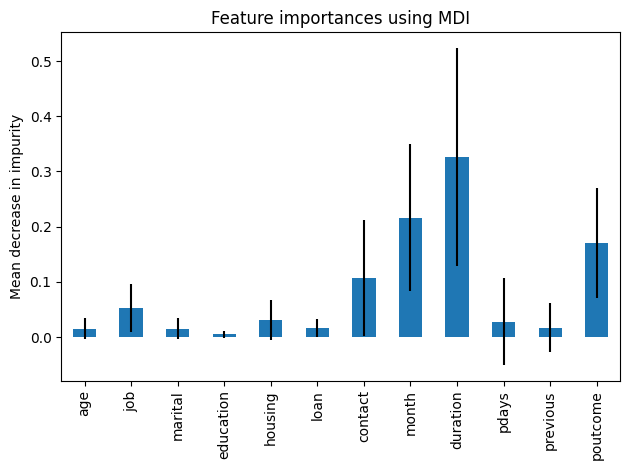

In [34]:
import matplotlib.pyplot as plt

forest_importances = pd.Series(importances, index=final_features)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()